In [1]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Data loading and transformation
data_dir = 'datasets/dataset1/train'  # Path to your dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [3]:
# Model setup
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)  # Assuming 7 expression categories

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\enesk\anaconda3\envs\facial-expression\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\enesk\anaconda3\envs\facial-expression\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\enesk/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:11<00:00, 8.85MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
import matplotlib.pyplot as plt

# Initialize lists to store per-epoch loss
train_losses = []
val_losses = []

num_epochs = 50  # Or any other number of epochs you're using
patience = 5
best_val_loss = np.Inf
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Calculate average losses
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1, Train Loss: 1.6443438377220982, Validation Loss: 1.6199677103095584
Epoch 2, Train Loss: 1.5514914610923831, Validation Loss: 1.57325625816981
Epoch 3, Train Loss: 1.5209148687240472, Validation Loss: 1.563679811027315
Epoch 4, Train Loss: 1.5084172881579332, Validation Loss: 1.4766780654589335
Epoch 5, Train Loss: 1.4815990002540493, Validation Loss: 1.525399602121777
Epoch 6, Train Loss: 1.4736286793578635, Validation Loss: 1.4683625823921627
Epoch 7, Train Loss: 1.47101105911486, Validation Loss: 1.572906462351481
Epoch 8, Train Loss: 1.4516179274383694, Validation Loss: 1.5334501975112491
Epoch 9, Train Loss: 1.4423216856123677, Validation Loss: 1.4930615842342376
Epoch 10, Train Loss: 1.4365897630250553, Validation Loss: 1.4442507836553786
Epoch 11, Train Loss: 1.4284305602395102, Validation Loss: 1.4450188636779786
Epoch 12, Train Loss: 1.433424348037555, Validation Loss: 1.4986550304624768
Epoch 13, Train Loss: 1.4106751786633123, Validation Loss: 1.4804840048154195
Epo

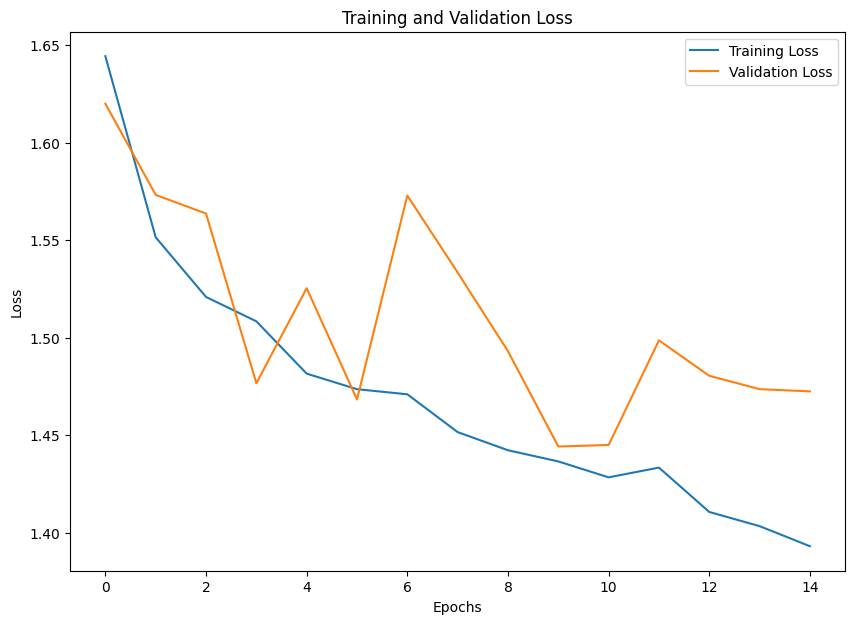

In [5]:
# Load the best model weights
model.load_state_dict(best_model_wts)

# Plotting training and validation loss
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [6]:
model_path = 'cnn_resnet.pth'
torch.save(model.state_dict(), model_path)